# Text Classification using LSTM model

Using the SMS Spam Collection dataset, which can be found at https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

Downloading the "stopwords" and "punkt" resources from the NLTK (Natural Language Toolkit) library. The "stopwords" resource contains a list of common words that can be filtered out during text preprocessing, while the "punkt" resource is used for tokenization.

In [1]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv("SMSSpamCollection.txt", sep="\t", header=None, names=["label", "text"])

In [6]:
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


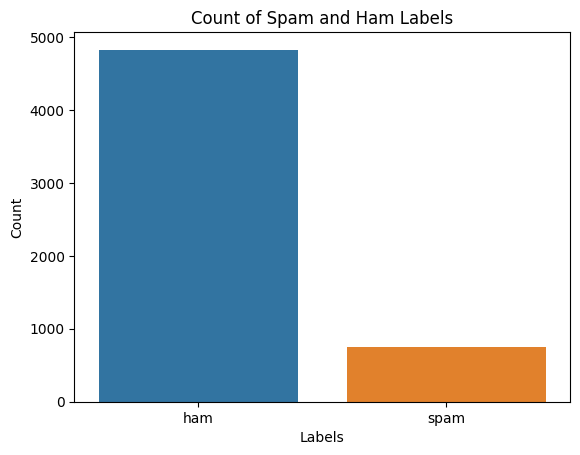

In [7]:
sns.countplot(x=data['label'])
plt.title('Count of Spam and Ham Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Converting all the characters in the input text to lowercase and removing any character that is not an alphabet or whitespace

In [11]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]

    return words

In [12]:
data["text"] = data["text"].apply(preprocess)

Initializing a Tokenizer object from the Keras library and fits it on the text data. The fit_on_texts function updates the internal vocabulary based on the given text data.

The texts_to_sequences function transforms the text data into sequences of integers, where each integer corresponds to a word in the tokenizer's vocabulary.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["text"])

Padding the sequences with zeros to make them all the same length (100 in this case) using the pad_sequences function from the Keras library. Padding is necessary because the input to the deep learning model should have a fixed size.

In [14]:
sequences = tokenizer.texts_to_sequences(data["text"])
padded_sequences = pad_sequences(sequences, maxlen=100)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

Encoding the y labels, (spam/ham), to binary.

In [15]:
X = padded_sequences
y = data["label"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

Building the LSTM model

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
112/112 [==============================] - 55s 437ms/step - loss: 0.2057 - accuracy: 0.9310 - val_loss: 0.0874 - val_accuracy: 0.9787
Epoch 2/5
112/112 [==============================] - 47s 423ms/step - loss: 0.0346 - accuracy: 0.9905 - val_loss: 0.0672 - val_accuracy: 0.9843
Epoch 3/5
112/112 [==============================] - 47s 418ms/step - loss: 0.0098 - accuracy: 0.9980 - val_loss: 0.0700 - val_accuracy: 0.9821
Epoch 4/5
112/112 [==============================] - 47s 415ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0877 - val_accuracy: 0.9832
Epoch 5/5
112/112 [==============================] - 48s 429ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0900 - val_accuracy: 0.9821


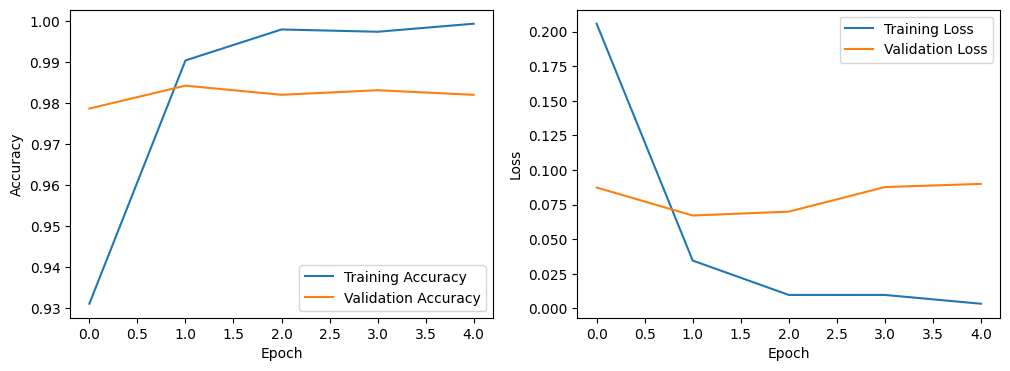

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [19]:
# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

35/35 [==============================] - 1s 29ms/step - loss: 0.0889 - accuracy: 0.9821
Test accuracy: 0.9820627570152283


35/35 [==============================] - 3s 77ms/step


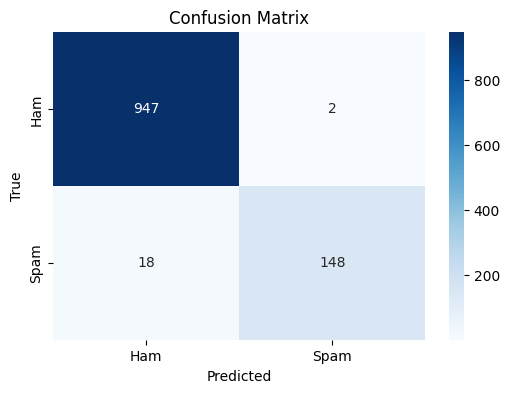

In [22]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).flatten().astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Predicting the label of a specific text

In [20]:
def predict_label(row_number):
    text = data.iloc[row_number]["text"]
    true_label = data.iloc[row_number]["label"]

    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=100)

    prediction = model.predict(padded_sequence)
    predicted_label = label_encoder.inverse_transform([1 if prediction[0][0] > 0.5 else 0])[0]


    print(f"Text: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted label: {predicted_label}")

In [21]:
example = 100
predict_label(example)

1/1 [==============================] - 0s 268ms/step
Text: ['please', 'dont', 'text', 'anymore', 'nothing', 'else', 'say']
True label: ham
Predicted label: ham


# Conclusion

By utilizing an LSTM model, we were able to achieve an impressive accuracy of 98.2% on the test set. This demonstrates the effectiveness of the deep learning approach for this text classification problem.

The success of this model can be attributed to several factors, including the proper preprocessing of the text data, the use of an appropriate neural network architecture (LSTM), and the optimization of the model's parameters.